# Image Generation
In this notebook we will continue our exploration of image gradients using the deep model that was pretrained on TinyImageNet. We will explore various ways of using these image gradients to generate images. We will implement class visualizations, feature inversion, and DeepDream.

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# TinyImageNet and pretrained model
As in the previous notebook, load the TinyImageNet dataset and the pretrained model.

In [2]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


 # Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [1]; [2] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I s_y(I) + R(I)
$$

where $R$ is a (possibly implicit) regularizer. We can solve this optimization problem using gradient descent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) + \lambda \|I\|_2^2
$$

and implicit regularization as suggested by [2] by peridically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[2] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [64]:
from cs231n import layers

def create_class_visualization(target_y, model, **kwargs):
    """
    Perform optimization over the image to generate class visualizations.
  
    Inputs:
    - layer: 
    - target_y: Integer in the range [0, 100) giving the target class
    - model: A PretrainedCNN that will be used for generation
  
    Keyword arguments:
    - learning_rate: Floating point number giving the learning rate
    - blur_every: An integer; how often to blur the image as a regularizer
    - l2_reg: Floating point number giving L2 regularization strength on the image;
      this is lambda in the equation above.
    - max_jitter: How much random jitter to add to the image as regularization
    - num_iterations: How many iterations to run for
    - show_every: How often to show the image
    """
  
    learning_rate = kwargs.pop('learning_rate', 10000)
    blur_every = kwargs.pop('blur_every', 1)
    l2_reg = kwargs.pop('l2_reg', 1e-6)
    max_jitter = kwargs.pop('max_jitter', 4)
    num_iterations = kwargs.pop('num_iterations', 200)
    show_every = kwargs.pop('show_every', 25)
    
    X = np.random.randn(1, 3, 64, 64)
    for t in xrange(num_iterations):
        # As a regularizer, add random jitter to the image
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        X = np.roll(np.roll(X, ox, -1), oy, -2)

        dX = None
        ############################################################################
        # TODO: Compute the image gradient dX of the image with respect to the     #
        # target_y class score. This should be similar to the fooling images. Also #
        # add L2 regularization to dX and update the image X using the image       #
        # gradient and the learning rate.                                          #
        ############################################################################
        
        # similar process as to generate fooling images in ImageGradients.ipynb

        scores, cache = model.forward(X, mode = "test")
        
        loss, dscores = layers.softmax_loss(scores, target_y)
        print loss
        
        dX, grads = model.backward(dscores, cache)
        
        dX += 2 * l2_reg * X
        
        X -= learning_rate * dX
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
    
        # Undo the jitter
        X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
        # As a regularizer, clip the image
        X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
    
        # As a regularizer, periodically blur the image
        if t % blur_every == 0:
            X = blur_image(X)
    
        # Periodically show the image
        if t % show_every == 0:
            plt.imshow(deprocess_image(X, data['mean_image']))
            plt.gcf().set_size_inches(3, 3)
            plt.axis('off')
            plt.show()
    return X

You can use the code above to generate some cool images! An example is shown below. Try to generate a cool-looking image. If you want you can try to implement the other regularization schemes from Yosinski et al, but it isn't required.

In [65]:
print "dataset contains:"
for k, v in data.items():
    print "\t", k
print "class names include:"
for class_name in data["class_names"]:
    print "\t", class_name

dataset contains:
	y_test
	X_val
	X_train
	y_train
	X_test
	y_val
	class_names
	mean_image
class names include:
	['Egyptian cat']
	['reel']
	['volleyball']
	['rocking chair', 'rocker']
	['lemon']
	['bullfrog', 'Rana catesbeiana']
	['basketball']
	['cliff', 'drop', 'drop-off']
	['espresso']
	['plunger', "plumber's helper"]
	['parking meter']
	['German shepherd', 'German shepherd dog', 'German police dog', 'alsatian']
	['dining table', 'board']
	['monarch', 'monarch butterfly', 'milkweed butterfly', 'Danaus plexippus']
	['brown bear', 'bruin', 'Ursus arctos']
	['school bus']
	['pizza', 'pizza pie']
	['guinea pig', 'Cavia cobaya']
	['umbrella']
	['organ', 'pipe organ']
	['oboe', 'hautboy', 'hautbois']
	['maypole']
	['goldfish', 'Carassius auratus']
	['potpie']
	['hourglass']
	['seashore', 'coast', 'seacoast', 'sea-coast']
	['computer keyboard', 'keypad']
	['Arabian camel', 'dromedary', 'Camelus dromedarius']
	['ice cream', 'icecream']
	['nail']
	['space heater']
	['cardigan']
	['baboon']


['volleyball']
6.7436003685


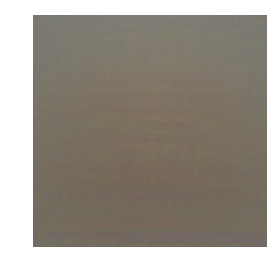

6.93820285797
5.19819355011
4.52273035049
3.97474479675
4.35421037674
2.55281567574
3.31824183464
1.71760070324
0.0855009630322
0.0162350609899
0.0187186002731
0.0169630162418
0.309471189976
0.023280646652
0.00974813383073
0.113831706345
0.0113897984847
0.0169569533318
0.0158519037068
0.150873675942
0.0381637699902
0.0369032509625
0.0317637100816
0.118883810937
0.0197106450796
0.0191274639219
0.0424682125449
0.10395142436
0.0245277695358
0.0230361558497
0.0247439704835
0.137466013432
0.0270709004253
0.0329637415707
0.0427290089428
0.0410448759794
0.251132577658
0.0300405584276
0.0183109361678
0.0282144807279
0.0403670743108
0.0330197997391
0.0649228617549
0.0591965988278
0.0385618321598
0.049273557961
0.0788950175047
0.0397653393447
0.0509733743966
0.0305725559592
0.177835211158
0.0211200471967
0.0460344068706
0.0293988399208
0.0241616331041
0.222581848502
0.0347464941442
0.0283407270908
0.0312286186963
0.103840984404
0.0758291855454
0.0884524658322
0.0374764092267
0.0313973166049
0.03

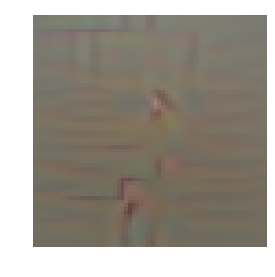

0.0613697841763
0.0204076152295
0.0451457947493
0.0602125525475
0.123252093792
0.021327232942
0.0340887345374
0.0572460442781
0.0975956693292
0.0437829717994
0.0515602454543
0.04430507496
0.0403076261282
0.0649280771613
0.0356539487839
0.0372334346175
0.049483589828
0.0486248880625
0.0393243916333
0.0944997668266
0.0293228495866
0.029799381271
0.210290491581
0.0356734059751
0.0217682309449
0.041257288307
0.0591318421066
0.03570997715
0.0611823312938
0.0523966625333
0.0233988277614
0.199815735221
0.0327322036028
0.0337219797075
0.0202978774905
0.0484452545643
0.044426266104
0.0585747025907
0.0402064174414
0.0413427613676
0.0697327926755
0.0359354056418
0.0257606059313
0.0388975217938
0.0874571204185
0.0983656197786
0.0347395204008
0.0816707834601
0.0450359284878
0.0707787722349
0.0318535454571
0.0727379098535
0.0409351475537
0.0539120584726
0.0456950627267
0.0334688201547
0.0478784032166
0.0582551509142
0.0550241693854
0.0454948693514
0.0702571794391
0.0508977994323
0.0874489247799
0.03

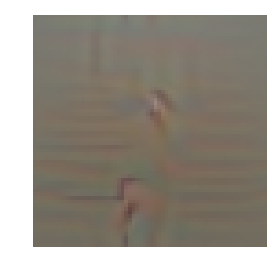

0.0576364956796
['parking meter']
5.34771537781


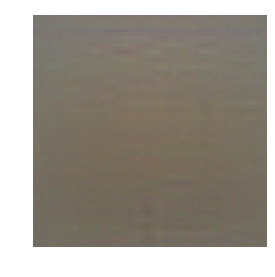

4.71024513245
2.99350786209
2.69381046295
2.20965600014
2.34079003334
2.70038437843
0.580636024475
0.0780702382326
1.81853222847
0.263171285391
0.203279584646
0.0573072060943
0.0817201957107
0.378410130739
0.134146228433
0.277044653893
0.044129639864
0.0248152744025
0.063573487103
0.116440013051
0.0984464511275
0.0898997560143
0.146023765206
0.0976542234421
0.04735699296
0.0614228285849
0.107922315598
0.165416017175
0.170337259769
0.0739394500852
0.121442750096
0.0531148500741
0.100505165756
0.0941361784935
0.0858939066529
0.0905633121729
0.0620044507086
0.121248401701
0.05522627756
0.0559938438237
0.263634741306
0.0905797556043
0.0903152450919
0.125646650791
0.0656681805849
0.0530495457351
0.062882848084
0.115228138864
0.0981223881245
0.0667015686631
0.121764972806
0.0645874142647
0.17651976645
0.0673882812262
0.0746769458055
0.0787228271365
0.0752531588078
0.242970407009
0.126963466406
0.0908639803529
0.115288935602
0.0557490363717
0.0920928046107
0.16700977087
0.101650223136
0.05921

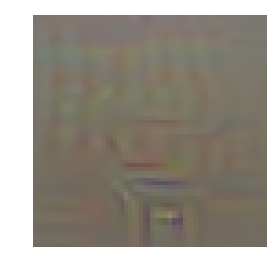

0.148036077619
0.0392220430076
0.0524945296347
0.0543080084026
0.0764435008168
0.0466973222792
0.118873737752
0.116041377187
0.0534853301942
0.0901423767209
0.111062452197
0.069676168263
0.0529543310404
0.040168505162
0.0773296579719
0.0576428100467
0.0763441026211
0.344631940126
0.0950267538428
0.0478762127459
0.159783840179
0.0801569372416
0.0835457742214
0.0605885833502
0.0495670773089
0.111860513687
0.0485737025738
0.0924176722765
0.0569912753999
0.262497365475
0.0599346235394
0.0795824751258
0.0808270424604
0.0605505891144
0.229868486524
0.107209995389
0.0437141656876
0.0440960042179
0.0563173405826
0.0614069849253
0.0791994929314
0.0781171545386
0.0914177894592
0.063992023468
0.0573238693178
0.0610559247434
0.0751595273614
0.0732793360949
0.0913389623165
0.0583102442324
0.0738201513886
0.0742641836405
0.117387481034
0.0630770325661
0.0920699313283
0.0507987737656
0.046471953392
0.0897997915745
0.117564924061
0.0739959925413
0.067455098033
0.0637902915478
0.0552189722657
0.0514497

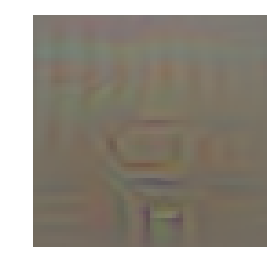

0.0449593663216
['tarantula']
4.84427499771


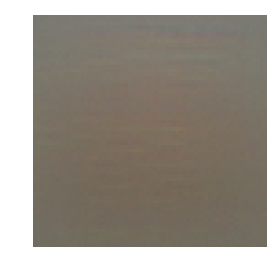

4.47381734848
4.17325353622
2.95492982864
2.72791290283
1.28181242943
1.96028792858
2.94706225395
4.20367860794
2.83362317085
1.65810501575
2.01361370087
0.446274936199
0.80297511816
0.273527741432
0.368882536888
0.101616837084
0.0626536756754
0.214494124055
0.154360070825
0.317377060652
0.107403621078
0.639466583729
0.151885509491
0.0341837778687
0.061613496393
0.064164750278
0.101059988141
0.074468486011
0.0608900673687
0.0553125143051
0.0576246865094
0.0440552011132
0.0715131014585
0.0702762305737
0.0572303906083
0.0923623666167
0.071033872664
0.182693585753
0.0489068254828
0.0984171852469
0.0412122532725
0.0613030493259
0.0209633018821
0.0470192655921
0.102102898061
0.032181635499
0.0674356520176
0.0330069847405
0.143803134561
0.0842076539993
0.0432015806437
0.0436379499733
0.0309259854257
0.0273930765688
0.052861135453
0.0696498379111
0.0336558967829
0.0403660200536
0.0696762949228
0.0198291335255
0.0364755578339
0.0255410056561
0.0411487147212
0.0387884639204
0.0201223455369
0.02

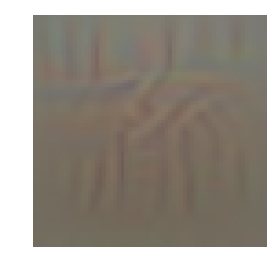

0.0365661270916
0.0363938361406
0.0447509661317
0.0293019209057
0.0251274332404
0.022060001269
0.0440172068775
0.0284123495221
0.0667955502868
0.0232691783458
0.0272607021034
0.0318635776639
0.0481993481517
0.0262362398207
0.0190718732774
0.0289197992533
0.0277659129351
0.0485844016075
0.0236843004823
0.0516663119197
0.200562015176
0.0227489154786
0.0664152652025
0.0245234929025
0.016129354015
0.0281367432326
0.025216858834
0.0210488848388
0.0238569788635
0.0572756454349
0.0294887684286
0.0639129802585
0.0187485404313
0.022122034803
0.0372151210904
0.0550286397338
0.0217539761215
0.0167616419494
0.0321107916534
0.0578522086143
0.0565549060702
0.0197519846261
0.0366565771401
0.0189097989351
0.0158731602132
0.0159901045263
0.0163040030748
0.0371953882277
0.0263906922191
0.042378410697
0.0197783075273
0.0720497593284
0.0178875997663
0.0143445655704
0.0465175956488
0.0174014251679
0.0221447646618
0.0286194570363
0.0243031252176
0.0169655010104
0.0238871946931
0.0940116867423
0.014199639670

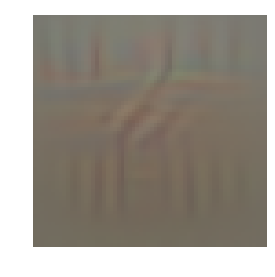

0.0256656911224


In [66]:
for target_y in [2, 10, 43]:
    print data["class_names"][target_y]
    create_class_visualization(target_y, model, show_every = 99)

# Feature Inversion
In an attempt to understand the types of features that convolutional networks learn to recognize, a recent paper [1] attempts to reconstruct an image from its feature representation. We can easily implement this idea using image gradients from the pretrained network.

Concretely, given a image $I$, let $\phi_\ell(I)$ be the activations at layer $\ell$ of the convolutional network $\phi$. We wish to find an image $I^*$ with a similar feature representation as $I$ at layer $\ell$ of the network $\phi$ by solving the optimization problem

$$
I^* = \arg\min_{I'} \|\phi_\ell(I) - \phi_\ell(I')\|_2^2 + R(I')
$$

where $\|\cdot\|_2^2$ is the squared Euclidean norm. As above, $R$ is a (possibly implicit) regularizer. We can solve this optimization problem using gradient descent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I') + \lambda \|I'\|_2^2
$$

together with implicit regularization by periodically blurring the image, as recommended by [2].

Implement this method in the function below.

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015

[2] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [67]:
def invert_features(target_feats, layer, model, **kwargs):
  """
  Perform feature inversion in the style of Mahendran and Vedaldi 2015, using
  L2 regularization and periodic blurring.
  
  Inputs:
  - target_feats: Image features of the target image, of shape (1, C, H, W), extracted from 
    forward pass till stop layer.
    we will try to generate an image that matches these features
  - layer: The index of the layer from which the features were extracted
  - model: A PretrainedCNN that was used to extract features
  
  Keyword arguments:
  - learning_rate: The learning rate to use for gradient descent
  - num_iterations: The number of iterations to use for gradient descent
  - l2_reg: The strength of L2 regularization to use; this is lambda in the
    equation above.
  - blur_every: How often to blur the image as implicit regularization; set
    to 0 to disable blurring.
  - show_every: How often to show the generated image; set to 0 to disable
    showing intermediate reuslts.
    
  Returns:
  - X: Generated image of shape (1, 3, 64, 64) that matches the target features.
  """
  learning_rate = kwargs.pop('learning_rate', 10000)
  num_iterations = kwargs.pop('num_iterations', 500)
  l2_reg = kwargs.pop('l2_reg', 1e-7)
  blur_every = kwargs.pop('blur_every', 1)
  show_every = kwargs.pop('show_every', 50)
  
  X = np.random.randn(1, 3, 64, 64)
  for t in xrange(num_iterations):
    ############################################################################
    # TODO: Compute the image gradient dX of the reconstruction loss with      #
    # respect to the image. You should include L2 regularization penalizing    #
    # large pixel values in the generated image using the l2_reg parameter;    #
    # then update the generated image using the learning_rate from above.      #
    ############################################################################

    # reconstruct an image I' from scratch.
    scores, cache = model.forward(X, end = layer, mode = "test")
    
    loss = np.sum(np.square(target_feats - scores)) + l2_reg * np.sum(np.square(X))
    print loss
    
    dscores = - 2 * (target_feats - scores)
    
    dX, grads = model.backward(dscores, cache)
        
    dX += 2 * l2_reg * X
        
    X -= learning_rate * dX
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # As a regularizer, clip the image
    X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
    
    # As a regularizer, periodically blur the image
    if (blur_every > 0) and t % blur_every == 0:
      X = blur_image(X)

    if (show_every > 0) and (t % show_every == 0 or t + 1 == num_iterations):
      plt.imshow(deprocess_image(X, data['mean_image']))
      plt.gcf().set_size_inches(3, 3)
      plt.axis('off')
      plt.title('t = %d' % t)
      plt.show()

### Shallow feature reconstruction
After implementing the feature inversion above, run the following cell to try and reconstruct features from the fourth convolutional layer of the pretrained model. You should be able to reconstruct the features using the provided optimization parameters.

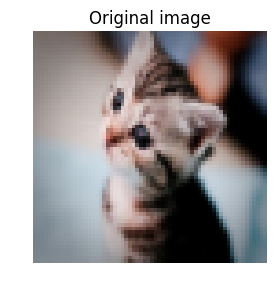

257.964565655


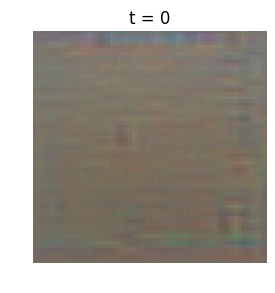

262.599614747
349.267949819
379.443272321
433.903110372
476.443932921
405.833628641
337.699831753
277.60590392
226.687868786
196.698912091
186.467169057
176.512272008
170.622071439
162.738819063
158.50430517
150.222558949
146.241204864
141.194576112
133.246975928
123.584127914
114.254322656
112.215175255
109.530307513
105.74018783
104.535111267
101.559158959
104.059464947
102.257084009
99.0536921847
92.6633201779
90.0904660041
86.0478677961
84.9975495629
82.464788122
79.043840913
77.5137495286
75.0310037677
73.59085382
77.7029274469
79.9437901082
77.6576099152
74.656043831
74.7610996889
74.7511118548
71.0641753187
66.6738894225
62.690305447
60.5454516711
60.752228936
58.0523365537
58.3967696039
61.9338428671
64.5819551937
70.1663822591
70.4856235236
72.1499225358
72.2735050375
71.3993951201
68.513090375
66.7417631011
60.7392091854
57.1193783014
56.9620573206
56.1167841073
54.3475744696
52.5107400182
50.3292099677
47.9519551008
47.88715065
48.1380144624
47.9760093664
49.8312192917
51.68

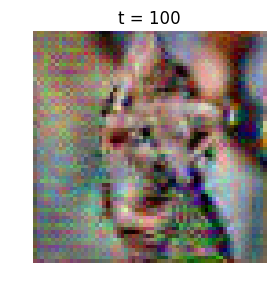

34.3655425371
35.157065573
38.1315245345
40.0592167921
41.4714871956
38.7135851607
38.1964859938
38.3611560586
41.8942894177
46.5339118941
45.1097422872
43.8254860587
37.8960399222
41.0490945565
41.5423163764
47.9858084355
35.9373455257
36.7658115378
31.4693859664
30.3957749127
29.6243526702
31.3445707789
33.9108455705
37.5036435358
33.8248885699
35.0641195169
32.7557235938
30.4205220991
28.7820248037
29.8971466967
30.0923460744
33.5947679862
31.2540056251
30.1527694555
28.3674972302
27.2679736033
26.7415818253
26.0795530624
28.0308019601
28.639424194
28.8792026399
29.2464308083
32.5248047498
32.5591921275
32.9544956097
32.0435038964
30.3933219875
30.2595515077
30.5719932253
27.2358199632
26.2398693951
26.2722410615
26.7295639129
26.3041413559
25.6029221752
25.941123514
25.1416178608
24.5351430376
27.3611297479
32.6804696992
31.0738064538
25.4892445998
24.2248171864
24.0684940652
26.6147318525
29.524653949
40.1569411201
46.7419357697
46.4527516615
37.3670362579
33.6782755991
30.6448356

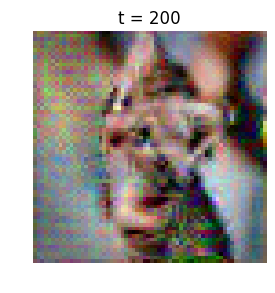

21.8344802475
24.5070059393
29.9128022309
40.0385176867
40.6810585313
41.9864676416
37.4157328474
32.6395371429
26.022361714
27.361431877
28.4841100213
25.5737095649
24.8767325965
22.4869537385
25.3519376031
26.045138033
25.8724735964
22.4430802333
20.478144872
20.5726359895
20.8525502538
18.0751378495
17.6604023409
18.2853177367
19.5923108634
17.0927074164
16.4558268837
16.063714796
15.8277406738
15.6474110658
15.7522309777
16.0340548642
16.2237591634
17.7260417725
19.378002592
23.4158204016
25.8091745623
27.456838164
28.1352605381
25.8288486976
29.944365987
35.7053166031
37.5765604987
42.5223900824
42.0714968759
32.5135602675
23.0170458324
18.6352684537
16.6275894146
15.403617589
15.1649338984
15.0186965961
14.9646200762
15.5095386518
15.605108016
15.0965935517
14.6185426939
14.6648895893
15.0957873862
14.857300808
15.3908337839
14.602837612
14.4471232053
13.6038374881
13.7357789965
13.2386843807
13.1842283223
12.9831342756
12.8657682394
12.4528545656
13.1424898501
12.9869247393
13.2

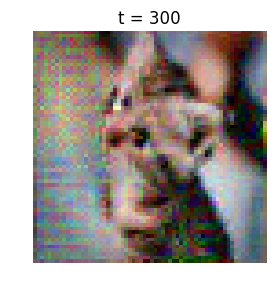

20.437892491
16.6988891502
17.1743720274
16.8999197257
16.8060471561
17.995360039
21.831686636
29.3676053933
28.8373312455
30.5201541061
22.3593359673
19.6477820718
17.7170944404
16.042305236
15.0625567834
14.0849187992
15.6040387961
15.7560056106
14.7098143962
12.5926057333
12.2570352147
12.0982825059
12.0962393693
13.7212783161
19.347293377
21.546029823
27.8061176706
28.87293483
27.9842295973
30.738418697
31.6599143388
29.22996826
29.5128921729
24.6593654259
20.9958526546
16.9635944706
18.5078740257
18.5327382872
15.8963576688
12.0849133843
10.7319532793
10.934362544
11.1856345923
10.7837749387
11.107502524
9.9313496644
9.50808845043
8.81804907903
8.75599376648
8.91468105176
10.0187852363
11.3770906275
10.7764331014
9.26989467607
9.5672336397
9.53014553812
9.26646410512
8.7386520576
9.47842817974
10.962713375
15.3369002078
18.1823552439
20.6335483747
23.7373282715
21.9459608643
26.1039174135
25.4267103737
28.1290555843
30.8786518208
30.1107092054
30.9373265124
23.2509817082
17.442462

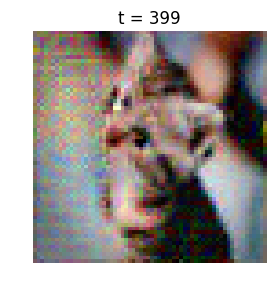

In [70]:
filename = 'kitten.jpg'
layer = 3 # layers start from 0 so these are features after 4 convolutions
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

# Preprocess the image before passing it to the network:
# subtract the mean, add a dimension, etc
img_pre = preprocess_image(img, data['mean_image'])

# Extract features from the image
feats, _ = model.forward(img_pre, end=layer)
# How to visualize the features?

# Invert the features
kwargs = {
  'num_iterations': 400,
  'learning_rate': 5000,
  'l2_reg': 1e-8,
  'show_every': 100,
  'blur_every': 10,
}
X = invert_features(feats, layer, model, **kwargs)

### Deep feature reconstruction
Reconstructing images using features from deeper layers of the network tends to give interesting results. In the cell below, try to reconstruct the best image you can by inverting the features after 7 layers of convolutions. You will need to play with the hyperparameters to try and get a good result.

HINT: If you read the paper by Mahendran and Vedaldi, you'll see that reconstructions from deep features tend not to look much like the original image, so you shouldn't expect the results to look like the reconstruction above. You should be able to get an image that shows some discernable structure within 1000 iterations.

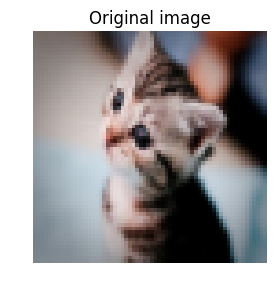

12.0258890696


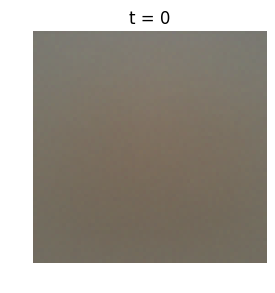

11.9105486476
11.7932365614
11.6897201981
11.6126978545
11.5312524051
11.4659948544
11.4004822912
11.3333118817
11.2719606865
11.1986309771
11.1399766705
11.0791448136
11.0063296901
10.9508383106
10.8995042432
10.8352628191
10.7720237698
10.7122272658
10.6734675112
10.6254685409
10.5888319553
10.5442778499
10.5052661908
10.4664265454
10.4279557806
10.377342723
10.3249932025
10.2587881889
10.203284892
10.1628395221
10.1351514701
10.0979913985
10.0667260408
10.0366172247
10.0028060936
9.97546098501
9.94866041852
9.92143429426
9.89387185422
9.87112682115
9.86151754336
9.83694960143
9.81426024532
9.78607226937
9.76391662635
9.74211839209
9.72047683742
9.69200594392
9.67135797129
9.64007945642
9.62615054936
9.59276456598
9.57061795691
9.54444861025
9.51794710926
9.49552079303
9.48065161987
9.46137441256
9.44751186359
9.4097057058
9.3931886248
9.36673835809
9.3452373323
9.32408018893
9.30376391
9.27558064111
9.26281277243
9.23160658589
9.20373067359
9.1796817804
9.16576903868
9.12861509916
9

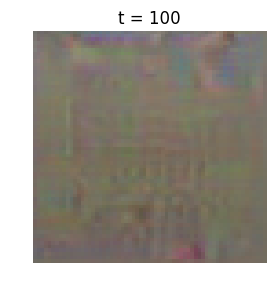

8.30946829901
8.28640029866
8.27549687059
8.25792661373
8.2505803492
8.2302639421
8.22688328662
8.21563103285
8.18025849095
8.15592602102
8.1578381896
8.13249913483
8.12227274592
8.10215410625
8.09180001214
8.07359542907
8.06526103635
8.04824403567
8.03240231837
8.00869940922
8.01378338273
7.9855476029
7.96871664865
7.9510742209
7.93876764945
7.90803454206
7.88731164615
7.87190942473
7.8596850936
7.84261046065
7.85029645444
7.82174769301
7.80193356748
7.79350512383
7.78705717735
7.76673402586
7.76316135766
7.73678887404
7.72286814813
7.70711209637
7.71948284824
7.68625464287
7.67922847823
7.66357746367
7.65736880307
7.62575959921
7.61181481163
7.59214285724
7.57841671275
7.56027266309
7.57193775818
7.54953628644
7.53917136952
7.51731040012
7.5052109094
7.48706040082
7.47227298478
7.45561034826
7.43993560468
7.41824305436
7.42592260808
7.38906275892
7.36624178802
7.34582394648
7.33142521749
7.31823894774
7.29956938446
7.280177307
7.26472643243
7.24683201077
7.26275179635
7.2257610613
7.

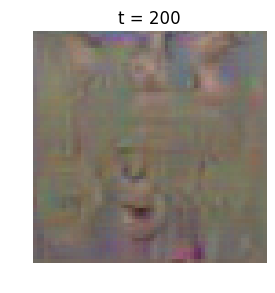

5.19453111767
5.13046338277
5.07434140153
5.0102029539
4.93896259283
4.88613532632
4.84192468022
4.79806113932
4.75851654461
4.74649678154
4.7984924299
4.68550950154
4.62018103179
4.54652689082
4.49472334777
4.42391898542
4.37660318858
4.33023586108
4.28398290174
4.20802075812
4.20112384797
4.13323615144
4.07627059774
4.00400554132
3.94158181362
3.89107368988
3.83984151941
3.79716687329
3.74647494118
3.71904183424
3.74602905215
3.71539889423
3.68277191577
3.63560839339
3.59767396639
3.54521332707
3.5094753797
3.48446037518
3.46534380125
3.45212015347
3.48659784612
3.44146370059
3.41199611337
3.38275345613
3.3575157738
3.33808691055
3.32225273588
3.31063685031
3.30481290268
3.28840304584
3.30744563818
3.2542211729
3.23765122602
3.19538886956
3.17088152301
3.13911578755
3.11708769991
3.09829111446
3.06917893367
3.05087958327
3.06629846178
3.03509537344
3.01172085123
2.99393766481
2.98156150564
2.97069135959
2.95629549807
2.94130095607
2.92658104699
2.90642356732
2.9326153392
2.8971125095

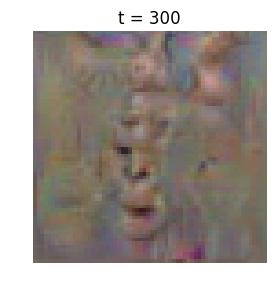

2.47480895198
2.43449940191
2.41996434051
2.40004811335
2.40389068651
2.38096498431
2.36559264363
2.34268129001
2.32556533435
2.2992511176
2.32967307272
2.29541814267
2.27662857966
2.25801517741
2.24580762584
2.23455545123
2.22905709218
2.21688920592
2.2126142604
2.19868096475
2.23276878249
2.1974225772
2.18058344219
2.16304725473
2.15297641848
2.13982341119
2.13256710305
2.12124263742
2.11253183889
2.09769061417
2.13356925098
2.10342357702
2.08661468222
2.07470037589
2.06762623136
2.05448793737
2.04677341689
2.03684580783
2.03128741119
2.01966144091
2.05989730386
2.03198889477
2.01869873411
2.00406742842
1.99303388193
1.97887739779
1.97066861974
1.95520837699
1.94473483141
1.93328425979
1.97486966974
1.94749268172
1.93233327782
1.92132209031
1.91429593752
1.90834623965
1.91069971666
1.8961822678
1.89010399172
1.8802345878
1.92622967012
1.88652567195
1.86598361296
1.8530002706
1.84384847517
1.83537676475
1.83127622301
1.82351744644
1.81985318315
1.81104129203
1.85134681022
1.8208681117

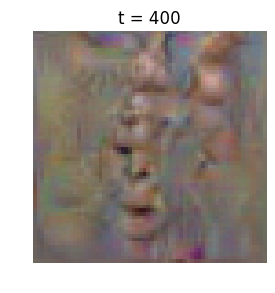

1.72802698251
1.69820210603
1.68633190066
1.67624452555
1.67051653256
1.66128355151
1.65730893394
1.65008920047
1.64916364673
1.64585956779
1.69207509857
1.67383949062
1.66861643803
1.66308150598
1.66169434173
1.64967418467
1.63974495159
1.62630165787
1.61344482987
1.60403451119
1.64428788706
1.62136992263
1.61110201608
1.60663608572
1.60189868934
1.6010308309
1.5956387491
1.59809448967
1.58904005556
1.58529887294
1.62284621656
1.59945898135
1.58426187278
1.57329783521
1.56564797754
1.55923726123
1.55343256472
1.54795921268
1.54256930697
1.53748170504
1.57868958734
1.55983958029
1.54976692653
1.54901866837
1.5439365096
1.54562246116
1.5407339505
1.54451265221
1.53497819637
1.52775811557
1.56364902437
1.53847736077
1.52423373992
1.51479151787
1.50807218628
1.5033321512
1.49924008222
1.49558526085
1.49230361129
1.48944873631
1.53137098026
1.51283514626
1.50263846423
1.49792437214
1.49107514083
1.48645501714
1.48164562409
1.47740380979
1.47249703248
1.46797764092
1.51096265347
1.490661501

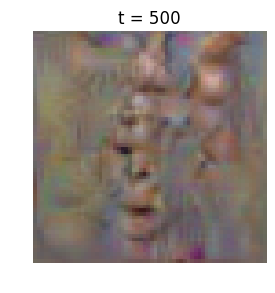

1.46243645898
1.43550368247
1.42604415142
1.41941495119
1.41418217661
1.40976597171
1.40658774079
1.40359332008
1.40387997402
1.40247605474
1.45525742058
1.43387293415
1.43061505414
1.42058108038
1.41668124129
1.40659124011
1.39975899406
1.39060920909
1.38522779466
1.37948707968
1.42295513705
1.39953848531
1.3899504952
1.38501759116
1.38077384722
1.37815412609
1.37584568682
1.37345276448
1.37203165719
1.3686190297
1.41353265233
1.39039299398
1.38457533691
1.3791231248
1.37635698358
1.37226825095
1.37105603549
1.36532652926
1.36328091283
1.3582740821
1.39796982608
1.37538162432
1.36781557278
1.36181619753
1.35917499608
1.35602503701
1.35430312501
1.35056082266
1.34782839471
1.34340214133
1.38595080554
1.3600224092
1.35130578781
1.3478458286
1.34632621359
1.34355041627
1.34126747602
1.33777466508
1.33893874271
1.33389347732
1.37462098192
1.34892855075
1.33985397096
1.33354326006
1.32986968335
1.32594245385
1.322308243
1.31861719652
1.31524262721
1.31151071309
1.35410779839
1.329980127
1.

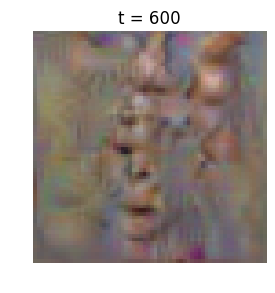

1.30648676798
1.28263837813
1.27205814692
1.26638395928
1.26236831699
1.25898590932
1.25694653093
1.25621177142
1.25982822001
1.26014364984
1.31044166213
1.28650473467
1.28021359033
1.26556239387
1.25607284528
1.24902157292
1.24422161903
1.23924799521
1.23572141375
1.23198772167
1.2757892399
1.25388461718
1.24427782753
1.23843648349
1.2346140042
1.23218674909
1.23087375511
1.22990722127
1.22846999092
1.22647531822
1.27232252145
1.2469839921
1.2371197274
1.231047958
1.22503052226
1.22120439883
1.21735368378
1.21265762263
1.2096676172
1.20691022417
1.25215156026
1.23016718043
1.22269662275
1.2174823472
1.21606278001
1.21083402265
1.20761976493
1.201556448
1.19773318014
1.19129365347
1.23321637327
1.21022788102
1.19979760294
1.19428834167
1.19067616223
1.18834033227
1.18804069036
1.18657537092
1.18820242176
1.18389363668
1.23084646136
1.20513250643
1.19392673606
1.18728851511
1.18356323855
1.17739850332
1.17405441296
1.16941003371
1.16394822457
1.15878830196
1.20760150279
1.18522452684
1.

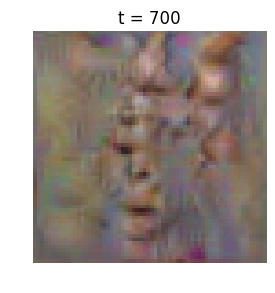

1.1606654865
1.13881328691
1.1290628334
1.12545962009
1.11999389212
1.11590807479
1.11261296874
1.1096578214
1.10663909187
1.10429220208
1.14803797335
1.12485892486
1.11499681163
1.11226856662
1.10947451162
1.10930679371
1.10840434712
1.10795755001
1.10308571864
1.10071101002
1.13966322625
1.11929107857
1.10986770765
1.10787526024
1.10019809766
1.09545492918
1.08954439239
1.08537620288
1.08050692733
1.07657413256
1.12069125933
1.09720560397
1.08866399511
1.0848545615
1.08048100277
1.0797221962
1.07504766239
1.07314377841
1.06848660812
1.06674523607
1.11348405016
1.09005766647
1.08082183376
1.07805093442
1.07247578963
1.0717186354
1.06621220577
1.06287783832
1.05689099704
1.05336480097
1.1012599968
1.07661764861
1.06672526468
1.06305170363
1.05823122639
1.05554582136
1.05217329511
1.04990957584
1.04600871177
1.04293083711
1.09005099766
1.06551411936
1.05515491507
1.05031266036
1.04974354322
1.04891026116
1.05363651569
1.05141190644
1.05131722496
1.04273769106
1.09141455756
1.06296619387

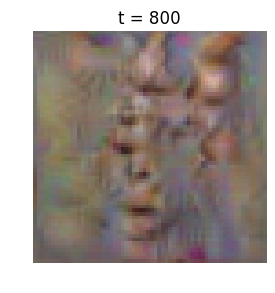

1.04827566306
1.02391171107
1.01520974072
1.00960334081
1.00638606263
1.00303799126
1.00131930021
0.997974156712
0.996745621181
0.992399863595
1.03903044707
1.01402948052
1.00583333974
1.00077005767
0.998112824743
0.994234633923
0.991746158012
0.987799208638
0.98604195952
0.98276199802
1.03204890638
1.00621912701
0.996915130986
0.992549937921
0.992512763805
0.98899535142
0.987799602418
0.983508368376
0.982946801664
0.978338147558
1.02622028119
0.999185424136
0.990254868432
0.984732199205
0.981804555953
0.977180039033
0.975679260758
0.972616637487
0.969839400781
0.967316710255
1.01622155213
0.989520112303
0.978289003495
0.973003881723
0.970302464686
0.967477848432
0.966222864774
0.962390982312
0.960018135878
0.956827165629
1.00545086797
0.978998697274
0.970409322228
0.965348469121
0.964378544256
0.961489486359
0.960758983915
0.9570256084
0.954069357637
0.949508690776
0.995265913043
0.968916874331
0.960345590209
0.955090666642
0.951238748435
0.948209263048
0.946354825564
0.943418558016
0

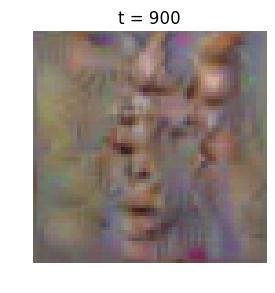

0.959610064323
0.933780622322
0.925118299992
0.920866701668
0.918354757708
0.915409058152
0.914361689367
0.911871388483
0.911154664326
0.908943623822
0.954158466867
0.929693969939
0.925187979521
0.920181326576
0.918329522766
0.913363363936
0.910783279736
0.905523668176
0.902918196248
0.898975596054
0.942093384619
0.917428370239
0.910605964294
0.90456454979
0.901942264448
0.898416782348
0.896683199289
0.894060702647
0.892340940146
0.889623129136
0.936352178298
0.911187179636
0.903973465513
0.898095903104
0.895296620278
0.891627719688
0.889353529702
0.885673891624
0.883747006405
0.88067447362
0.926408548436
0.900657113138
0.893110589023
0.887393379002
0.885428499374
0.88138672992
0.879610565971
0.876314903185
0.874197868869
0.870943308881
0.915424224901
0.890181475413
0.883668917722
0.879289744269
0.87734546593
0.874257962693
0.873011563888
0.869922570232
0.869005113785
0.865697735335
0.910374639967
0.885460338666
0.878441651233
0.873766827686
0.871206438859
0.867867117373
0.865966777092

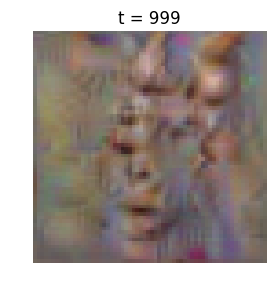

In [72]:
filename = 'kitten.jpg'
layer = 6 # layers start from 0 so these are features after 7 convolutions
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

# Preprocess the image before passing it to the network:
# subtract the mean, add a dimension, etc
img_pre = preprocess_image(img, data['mean_image'])

# Extract features from the image
feats, _ = model.forward(img_pre, end=layer)

# Invert the features
# You will need to play with these parameters.
kwargs = {
  'num_iterations': 1000,
  'learning_rate': 5000,
  'l2_reg': 1e-8,
  'show_every': 100,
  'blur_every': 10,
}
X = invert_features(feats, layer, model, **kwargs)

# DeepDream
In the summer of 2015, Google released a [blog post](http://googleresearch.blogspot.com/2015/06/inceptionism-going-deeper-into-neural.html) describing a new method of generating images from neural networks, and they later [released code](https://github.com/google/deepdream) to generate these images.

The idea is very simple. We pick some layer from the network, pass the starting image through the network to extract features at the chosen layer, set the gradient at that layer equal to the activations themselves, and then backpropagate to the image. This has the effect of modifying the image to amplify the activations at the chosen layer of the network.

For DeepDream we usually extract features from one of the convolutional layers, allowing us to generate images of any resolution.

We can implement this idea using our pretrained network. The results probably won't look as good as Google's since their network is much bigger, but we should still be able to generate some interesting images.

In [75]:
def deepdream(X, layer, model, **kwargs):
  """
  Generate a DeepDream image.
  
  Inputs:
  - X: Starting image, of shape (1, 3, H, W)
  - layer: Index of layer at which to dream
  - model: A PretrainedCNN object
  
  Keyword arguments:
  - learning_rate: How much to update the image at each iteration
  - max_jitter: Maximum number of pixels for jitter regularization
  - num_iterations: How many iterations to run for
  - show_every: How often to show the generated image
  """
  
  X = X.copy()
  
  learning_rate = kwargs.pop('learning_rate', 5.0)
  max_jitter = kwargs.pop('max_jitter', 16)
  num_iterations = kwargs.pop('num_iterations', 100)
  show_every = kwargs.pop('show_every', 25)
  
  for t in xrange(num_iterations):
    # As a regularizer, add random jitter to the image
    ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
    X = np.roll(np.roll(X, ox, -1), oy, -2)

    dX = None
    ############################################################################
    # TODO: Compute the image gradient dX using the DeepDream method. You'll   #
    # need to use the forward and backward methods of the model object to      #
    # extract activations and set gradients for the chosen layer. After        #
    # computing the image gradient dX, you should use the learning rate to     #
    # update the image X.                                                      #
    ############################################################################
    
    scores, cache = model.forward(X, end = layer, mode = "test")
    
    dscores = scores
    
    dX, grads = model.backward(dscores, cache)
    
    X -= learning_rate * dX
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # Undo the jitter
    X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
    # As a regularizer, clip the image
    mean_pixel = data['mean_image'].mean(axis=(1, 2), keepdims=True)
    X = np.clip(X, -mean_pixel, 255.0 - mean_pixel)
    
    # Periodically show the image
    if t == 0 or (t + 1) % show_every == 0:
      img = deprocess_image(X, data['mean_image'], mean='pixel')
      plt.imshow(img)
      plt.title('t = %d' % (t + 1))
      plt.gcf().set_size_inches(8, 8)
      plt.axis('off')
      plt.show()
  return X

# Generate some images!
Try and generate a cool-looking DeepDeam image using the pretrained network. You can try using different layers, or starting from different images. You can reduce the image size if it runs too slowly on your machine, or increase the image size if you are feeling ambitious.

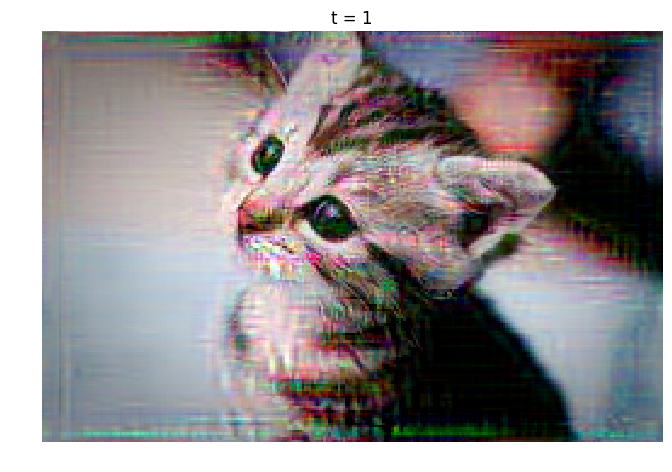

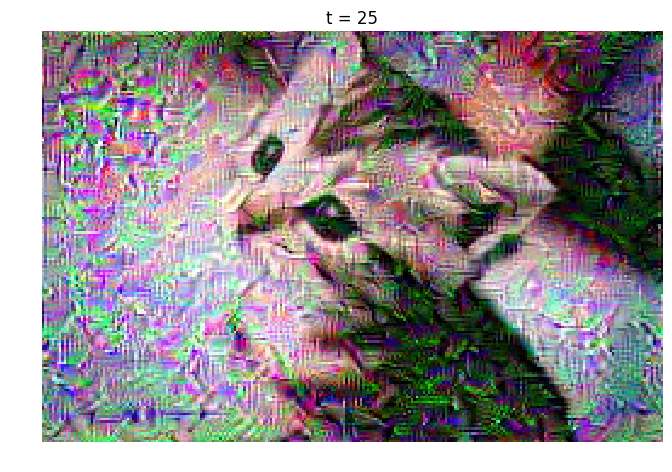

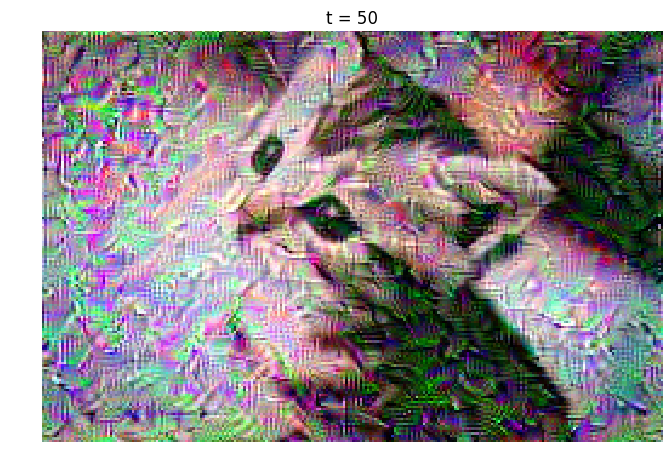

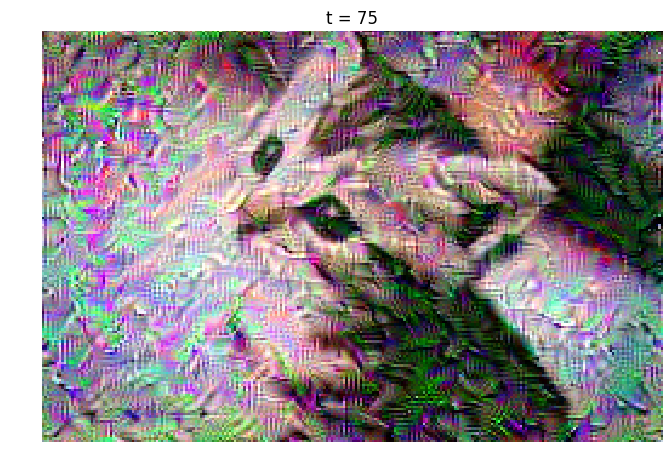

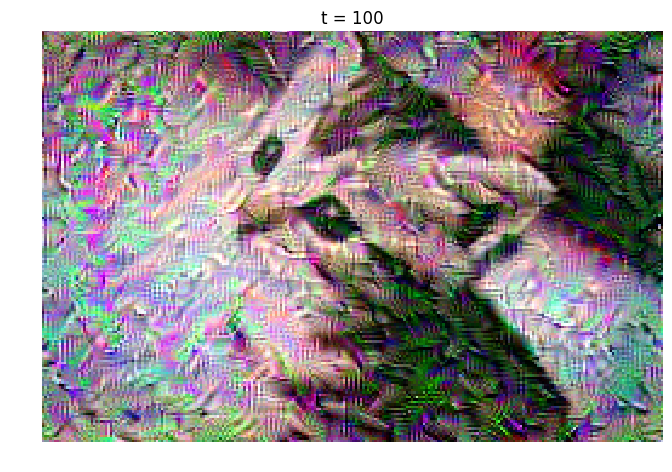

In [80]:
def read_image(filename, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

filename = 'kitten.jpg'
max_size = 256
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 5, model, learning_rate=50000)